In [1]:
import cProfile
import re
import scipy
import numpy as np
import random


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cd C:\Users\ArianStolk\Documents\GitHub\SPDC


C:\Users\ArianStolk\Documents\GitHub\SPDC


In [3]:
%run main.py
%run physics.py

In [4]:


# Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,3],thickness = 6,orientation="up",cutangle=28.76*np.pi/180)
# HalfWave = HWP(name='Hwp',material=None,position=[0,0,7],thickness=0,cutoff=500)
# Crystal2=Crystal(name = 'BBO2',material = 'BBO',position = [0,0,11],thickness = 6,orientation="up",cutangle=28.76*np.pi/180)
# Crystal3=Crystal(name = 'YVO1',material = 'YVO4',position = [0,0,19],thickness = 3.12 ,orientation="left",cutangle=90*np.pi/180)
# ACH=Lens.asphere(position = [0,0,60],centre=[-0.6,0,0],f= 50)
# Csetup=ExpSetup(Crystal1,HalfWave,Crystal2,Crystal3,ACH)
# sim=Simulation(rays=[0],setup=Csetup,store_path=True,store_time=True)
# sim.run(Ntot=1000000,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=[0.06,0.03],pump_focus=[8,8],l_min=650,theta_min=-2*np.pi/180,theta_max=2*np.pi/180,cutangle=28.76*np.pi/180)
# SPDC_list=sim.start_list
# print(len(sim.complete_results[0][0]))




In [5]:
def get_interpolation_matrices(rays,centre,diam):
    Hit_Lens_True=[]
    for i,ray in enumerate(rays):
        Hit_Lens_True.append(((ray[0][...,8][...,0:2]-np.array(centre))*(ray[0][...,8][...,0:2]-np.array(centre))).sum(axis=1)<(diam**2)/4)
    
    comb_truthH=np.logical_and(Hit_Lens_True[0],Hit_Lens_True[1])
    comb_truthV=np.logical_and(Hit_Lens_True[2],Hit_Lens_True[3])

    result_matrices = [np.float32(rays[0][0][...,-2][...,0:2][comb_truthH]),np.float32(rays[0][0][...,-1][...,0:2][comb_truthH]),np.float32(rays[1][0][...,-2][...,0:2][comb_truthH]),np.float32(rays[1][0][...,-1][...,0:2][comb_truthH]),np.float32(rays[2][0][...,-2][...,0:2][comb_truthV]),np.float32(rays[2][0][...,-1][...,0:2][comb_truthV]),np.float32(rays[3][0][...,-2][...,0:2][comb_truthV]),np.float32(rays[3][0][...,-1][...,0:2][comb_truthV])]
    
    z_beg_val=np.float32(rays[0][0][...,-2][0][...,2])
    z_end_val=np.float32(rays[0][0][...,-1][0][...,2])
    
    result_matrices.append(z_beg_val)    
    result_matrices.append(z_end_val)
    
    return result_matrices

def get_results_evol(visualization,x):
    visualization.filter_results(fibre_pos=np.array(x),core_diam = fibre_diam ,Num_Ap=fibre_NA)
#     Hit_Lens_True=((visualization.complete_results[0][0][...,8][...,0:2]-np.array([-0.6,0]))*(visualization.complete_results[0][0][...,8][...,0:2]-np.array([-0.6,0]))).sum(axis=1)<(7.5**2)/4
    
#     dummy_new=[[[] for _ in range(5)] for _ in range(4)]
#     for i,dummy_list in enumerate(visualization.dummy_surface):
#         Hit_Lens_True=((visualization.complete_results[i][0][...,8][...,0:2]-np.array([-0.6,0]))*(visualization.complete_results[i][0][...,8][...,0:2]-np.array([-0.6,0]))).sum(axis=1)<(7.5**2)/4

#         for j,attr in enumerate(dummy_list[0:-2]):
#             dummy_new[i][j]=attr[Hit_Lens_True]
                
#     visualization.dummy_surface=dummy_new 

    
#     visualization.filter_results(fibre_pos=np.array(x),core_diam = fibre_diam ,Num_Ap=fibre_NA)
    coinc=len(visualization.coincidences[0][0])+len(visualization.coincidences[2][0])

#     signalH_e=(coinc)/(len(visualization.singles[1][0])+1)
#     idlerH_e=(coinc)/(len(visualization.singles[0][0])+1)
#     signalV_e=(coinc)/(len(visualization.singles[3][0])+1)
#     idlerV_e=(coinc)/(len(visualization.singles[2][0])+1)
    print("final coinc are",coinc)
#     spectrumH=np.histogram(np.concatenate((visualization.singles[0][2],visualization.singles[1][2])),np.linspace(600,1100,100))
#     spectrumV=np.histogram(np.concatenate((visualization.singles[2][2],visualization.singles[3][2])),np.linspace(600,1100,100))
    return [visualization.coincidences,visualization.singles,visualization.coincidences_SPDC_list,x]
        
        

# def get_coinc_evol(x,focus_z,diam,numap,lenspos,fac=10):
#     fibre_position=vis2.get_focus_pos(pos=rays_end + x[2]+lenspos + focus_z)+np.array([x[0],x[1],0])
#     vis2.filter_results(fibre_pos=fibre_position,core_diam = diam,Num_Ap=numap)
    
#     return fac*abs(len(vis2.coincidences[0][0])-len(vis2.coincidences[2][0]))-len(vis2.coincidences[0][0])-len(vis2.coincidences[2][0])

def get_counts_evol(x,diam,numap):
    vis2.filter_results(fibre_pos=x,core_diam = diam,Num_Ap=numap)
    return [vis2.coincidences,vis2.singles,vis2.coincidences_SPDC_list,x]

def focus_setup(y,sbeg,send,ibeg,iend,z_beg,z_end,offset=0):
    returnlist=[]
    pos=offset+y
    
    scale=((pos-z_beg)/(z_end-z_beg))
#     scale=((pos-z_beg)/(z_end-z_beg))[0]
    
    signal=sbeg+(send-sbeg)*scale
    idler=ibeg+(iend-ibeg)*scale

    spot_sig=np.histogram2d(signal[:,0],signal[:,1],[np.linspace(-0.8,-0.2,20),np.linspace(-0.2,0.2,10)])[0]
    spot_idl=np.histogram2d(idler[:,0],idler[:,1],[np.linspace(-0.8,-0.2,20),np.linspace(-0.2,0.2,10)])[0]
    
    comb_spot=(spot_sig+spot_idl)
    
    return np.max(comb_spot)

3645


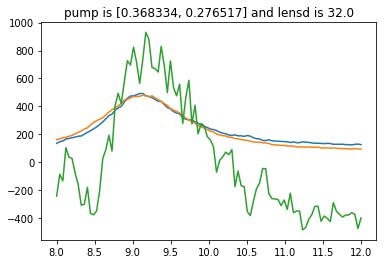

936.0 9.22613065327
0.15 0.025 1 [-0.6, 0, 41.226130653266331]
coincidences are 452.0 (9, 10, 62)
0.1125 0.016875 0.805 [-0.60789472, 0.0013157895, 41.058346]
coincidences are 566.0 (10, 9, 78)
0.056953125 0.0094921875 0.42564375 [-0.60197365, 0.00042763163, 41.096165]
coincidences are 578.0 (10, 9, 73)
0.0216243896484 0.00400451660156 0.166400103516 [-0.59897614, -7.1957184e-05, 41.087593]
coincidences are 584.0 (9, 10, 69)
0.0068420920372 0.00114034867287 0.0515970320979 [-0.60011429, 0.00013880685, 41.07531]
coincidences are 582.0 (9, 7, 94)
0.00162366051273 0.000324732102547 0.0141216642732 [-0.60047442, -0.0001612849, 41.088814]


KeyboardInterrupt: 

In [6]:
Optimize = True
xrange=np.linspace(1,5,25)
# lensd_coinc=[[],[],[]]
# lensd_result=[[],[],[]]
# result_list=np.load("C:/Users/Arian Stolk/Documents/optim_sweep_10112017_20to100d5_foc04_asph75.npz")['arr_0']
# pump_M2_list=np.array([[1.0577,1.1076],[1.4723,1.0191],[1.6733,1]])*1
# pumps = [[0.098334,0.096517],[0.096551,0.052454],[0.081456,0.025478]]
# pump_focus_list=[[7,7],[7,7],[7,7]]
pump_M2_list=np.array([[1.,1.],[1.4723,1.0191],[1.6733,1]])*1
pumps = [[0.368334,0.276517],[0.096551,0.052454],[0.081456,0.025478]]
pump_focus_list=[[7,7],[7,7],[7,7]]
lensd_fibre=[[[] for x in range(len(xrange))]for y in pumps]
lensd_photons=[[[] for x in range(len(xrange))]for y in pumps]
# lensd_fibre=[[[] for x in range(len([8,8,8]))]for y in pumps]
# lensd_photons=[[[] for x in range(len([8,8,8]))]for y in pumps]

for i in [0]:
    fibre_NA=[0.1,0.1,0.22][2]
    fibre_diam=[0.005,0.025,0.05][2]
    pump_M2=pump_M2_list[i]
    pump=pumps[i]
    pump_focus=pump_focus_list[i]
#     for j,holes in enumerate([8,8,8]): 
    for j,holes in enumerate(xrange):
#         for j,holes in enumerate([2,2.5,3,3.5,4,4.5,5,6,7,9,10,11]):
        lensd=7+25*holes
        Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,3],thickness = 6,orientation="up",cutangle=28.76*np.pi/180)
        HalfWave = HWP(name='Hwp',material=None,position=[0,0,7],thickness=0,cutoff=500)
        Crystal2=Crystal(name = 'BBO2',material = 'BBO',position = [0,0,11],thickness = 6,orientation="up",cutangle=28.76*np.pi/180)
        Crystal3=Crystal(name = 'YVO1',material = 'YVO4',position = [0,0,19],thickness = 3.12,orientation="left",cutangle=90*np.pi/180)
        ACH=Lens.achromat_aitor_r(position = [0,0,lensd],centre=[-0.6,0,0],f=250)
        ASPH=Lens.asphere_r(position = [0,0,lensd],centre=[-0.6,0,0],f=250)
        Csetup=ExpSetup(Crystal1,HalfWave,Crystal2,Crystal3,ASPH)
        sim2=Simulation(rays=[0],setup=Csetup,calc_phase=True)
        sim2.run(Ntot=1000000,nr_crystals=2,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2)
        print(len(sim2.complete_results[0][0]))
        vis2=Visualization(simulation=sim2)
        [Hsbeg,Hsend,Hibeg,Hiend,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val]=get_interpolation_matrices(vis2.complete_results,[-0.6,0],7.5)

        [Hsbeg,Hsend,Hibeg,Hiend]=Visualization.select_NA_TRUE(Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val)
        [Vsbeg,Vsend,Vibeg,Viend]=Visualization.select_NA_TRUE(Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val)
        
        plt.figure()
        plt.plot(np.linspace(8,12,100),[focus_setup(x,Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val,offset=lensd) for x in np.linspace(8,12,100)])
        plt.plot(np.linspace(8,12,100),[focus_setup(x,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val,offset=lensd) for x in np.linspace(8,12,100)])
        plt.plot(np.linspace(8,12,100),[focus_setup(x,Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val,offset=lensd)+focus_setup(x,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val,offset=lensd)-np.abs(focus_setup(x,Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val,offset=lensd)-focus_setup(x,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val,offset=lensd))*20 for x in np.linspace(8,12,100)])
        plt.title("pump is {} and lensd is {}".format(pump,lensd))
        plt.show()

#             [(vis2.showpos_single(pos = x+lenspos),print(focus_setup(x+lenspos,sbeg,send,ibeg,iend,z_beg_val,z_end_val))) for x in np.linspace(15,21,25)]

#         print(np.min([vis2.showpos_single(pos=x+lenspos) for x in np.linspace(0,100,100)]))
        if Optimize:
            scanlist=[focus_setup(x,Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val,offset=lensd)+focus_setup(x,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val,offset=lensd)-np.abs(focus_setup(x,Hsbeg,Hsend,Hibeg,Hiend,z_beg_val,z_end_val,offset=lensd)-focus_setup(x,Vsbeg,Vsend,Vibeg,Viend,z_beg_val,z_end_val,offset=lensd))*20 for x in np.linspace(8,12,200)]
            result_for_foc=[np.max(scanlist),np.linspace(8,12,200)[np.argmax(scanlist)]]
            print(result_for_foc[0],result_for_foc[1])
            search_pos=[-0.6,0,result_for_foc[1]+lensd]

            dx=0.15
            dy=0.025
            dz=1
            res=np.empty((20,20,150))
            scale=1
            scale_evol=0.75
            coinc_start= 0
            coincs= 0
            been_0=False
            while dz>0.01 and dz<10 :

                    print(dx,dy,dz,search_pos)

                    x_range=np.linspace(search_pos[0]-dx,search_pos[0]+dx,20,dtype=np.float32)
                    y_range=np.linspace(search_pos[1]-dy,search_pos[1]+dy,20,dtype=np.float32)
                    z_range=np.linspace(search_pos[2]-dz,search_pos[2]+dz,150,dtype=np.float32)

                    Hres=d_coinc(Hsbeg, Hsend ,Hibeg,Hiend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                    Vres=d_coinc(Vsbeg, Vsend ,Vibeg,Viend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                    coincs=np.max(Hres+Vres-20*np.abs(Hres-Vres))
                    maxindex=np.unravel_index(np.argmax(Hres+Vres-20*np.abs(Hres-Vres)),res.shape)


                    if coincs < 2:
                        dx *= 1.
                        dy *= 1.
                        dz *= 1.1
#                             search_pos[2]+=1
                        been_0 =True
#                             if not coincs == 0: 
#                                 search_pos[2] = z_range[maxindex[2]]
                        dx = max(0.2,dx)
                        dy = max(0.05,dy)


                    else:
                        if been_0:
                            dx=0.1
                            dy=0.02
                            dz=1.5
                            been_0 = False

                        scale *=scale_evol 
                        dx *= scale*(0.9+2*((abs(maxindex[0]-10))/20))
                        dy *= scale*(0.9+2*((abs(maxindex[1]-10))/20))
                        dz *= scale*(0.9+2*((abs(maxindex[2]-75))/150))

#                         dx *= 2/100
#                         dy *= 2/60
#                         dz *= 2/100

                        search_pos = [x_range[maxindex[0]],y_range[maxindex[1]],z_range[maxindex[2]]]
                    print("coincidences are",coincs,maxindex)
            print(search_pos)
            lensd_fibre[i][j]=search_pos
            
            del sim2.start_list
            del sim2.complete_results
            sim2.interpol_pos = 0
#             print(hasattr(sim2,'start_list'))
            sim2.run(Ntot=240000000,nr_crystals=2,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2)
            print(len(sim2.complete_results))
            vis_result=Visualization(simulation=sim2)
            vis_result.SPDC_list=sim2.start_list
            lensd_photons[i][j] = get_results_evol(vis_result,search_pos)


In [ ]:
big_results=lensd_photons
dist_list=[x*25 for x in xrange]
c=3*1e8

def showresults_sweep(results= big_results[0]):
    overlaplist=[]
    for i,x in enumerate(results):
        if len(x[0][0][3])>0 and len(x[0][1][3])>0 and len(x[0][2][3])>0 and len(x[0][3][3])>0:
            bins1=np.histogram(1e15*(x[0][0][3]-x[0][1][3]),bins=np.linspace(-200,1700,1900/50))
            bins2=np.histogram(1e15*(x[0][2][3]-x[0][3][3]),bins=np.linspace(-200,1700,1900/50))
            overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0]))
            overlaplist.append(overlap)
        else:
            overlaplist.append(0)
   
    y = dist_list
    
    fig, ax = plt.subplots(2, 3,figsize=(12,6))
    
    ax[1,0].plot(y,[[len(x[0][0][0]),len(x[0][2][0])] for x in results])
    ax[1,0].set_title('Coincidences')
    
    ax[1,1].plot(y,overlaplist)
    ax[1,1].set_title('TO of H and V')
    
    ax[0,0].plot(y,[x[3][2]-y[k] for k,x in enumerate(results)])
    ax[0,0].set_title('fibre pos Z')
    
    ax[0,1].plot(y,[x[3][1] for x in results])
    ax[0,1].set_title('fibre pos y')
    
    ax[0,2].plot(y,[x[3][0] for x in results])
    ax[0,2].set_title('fibre pos x')

    ax[1,2].plot(y,[[(len(x[0][0][0])+len(x[0][2][0]))/(1+len(x[1][0][0])+len(x[1][2][0])),(len(x[0][0][0])+len(x[0][2][0]))/(1+len(x[1][1][0])+len(x[1][3][0]))]  if (len(x[1][0][0])+len(x[1][2][0]))>0 else [0,0] for x in results])
    ax[1,2].set_title('Coupling efficiency of Signal and Idler photons')
      
    
    plt.show()
    
#     plt.figure()
#     plt.plot(y,[[len(x[1][0][0]),len(x[1][1][0]),len(x[1][2][0]),len(x[1][3][0])] for x in results],label=['1','2','3','4'])
#     plt.legend()
#     plt.title('Singles for H and V with respect to lens position')
#     plt.show()
    

#     for i,x in enumerate(results):
#         plt.figure()
#         plt.hist(np.concatenate((x[1][0][2],x[1][1][2])),np.linspace(600,1100,500/10),alpha=0.5)
#         plt.hist(np.concatenate((x[1][2][2],x[1][3][2])),np.linspace(600,1100,500/10),alpha=0.5)
#         plt.title('TO H and V is {:03.1f}%'.format(100*overlaplist[i]))
#         plt.show()
            
# ###Temporal information ###          
#     for i,x in enumerate(results):
#         f, axarr = plt.subplots(1, 2,figsize=(20,10))
#         const_phase=np.min((x[0][2][3]/x[0][2][2]+x[0][3][3]/x[0][3][2])/2)
        
#         axarr[0].hist(1e9*2*np.pi*c*((x[0][0][3]/x[0][0][2]+x[0][1][3]/x[0][1][2])/2-const_phase),100,alpha=0.5)
#         axarr[0].hist(1e9*2*np.pi*c*((x[0][2][3]/x[0][2][2]+x[0][3][3]/x[0][3][2])/2-const_phase),100,alpha=0.5)
        
#         axarr[1].hist(1e9*2*np.pi*c*((x[0][0][3]/x[0][0][2]-x[0][1][3]/x[0][1][2])/2),100,alpha=0.5)
#         axarr[1].hist(1e9*2*np.pi*c*((x[0][2][3]/x[0][2][2]-x[0][3][3]/x[0][3][2])/2),100,alpha=0.5)

#         bins1=np.histogram(1e15*(x[0][0][3]-x[0][1][3]),bins=np.linspace(-200,2000,2200/50))
#         bins2=np.histogram(1e15*(x[0][2][3]-x[0][3][3]),bins=np.linspace(-200,2000,2200/50))
#         overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0],1))

#         f.suptitle('TO H and V is {:03.1f}%, d = {:3.0f}'.format(overlap*100,dist_list[i]))
#         plt.show()

# ###Start positions###          
#     for i,x in enumerate(results):
#         f, axarr = plt.subplots(1, 3,figsize=(20,10))
        
#         for j in range(3):
#             axarr[j].hist((np.concatenate((x[2][0][0],x[2][1][0])).T)[j],bins=[np.linspace(-1,0.2,20),np.linspace(-0.5,0.5,20),np.linspace(0,6,20)][j],alpha=0.5)
#             axarr[j].hist([0.4,0,0][j]+(np.concatenate((x[2][2][0],x[2][3][0])).T)[j],bins=[np.linspace(-1,0.2,20),np.linspace(-0.5,0.5,20),np.linspace(8,14,20)][j],alpha=0.5)

#             bins1=np.histogram(1e15*(x[0][0][3]-x[0][1][3]),bins=np.linspace(-200,2000,2200/50))
#             bins2=np.histogram(1e15*(x[0][2][3]-x[0][3][3]),bins=np.linspace(-200,2000,2200/50))
#             overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0],1))

#             f.suptitle('TO H and V is {:03.1f}%, d = {:3.0f}'.format(overlap*100,dist_list[i]))
#         plt.show()

# ######Start angles#########
#     for i,x in enumerate(results):
#         opangle_H = np.sign([y[0] for y in x[2][0][1]])*0.5*np.linalg.norm((x[2][0][1]-x[2][1][1]),axis=1)
#         opangle_V = np.sign([y[0] for y in x[2][2][1]])*0.5*np.linalg.norm((x[2][2][1]-x[2][3][1]),axis=1)
        
#         propangle_H = 0.5*(x[2][0][1]+x[2][1][1])
#         propangle_V = 0.5*(x[2][2][1]+x[2][3][1])
#         f, axarr = plt.subplots(1, 3,figsize=(20,10))
        
#         axarr[0].hist(180/np.pi*opangle_H,np.linspace(-1.8,1.8,40),alpha=0.5)
#         axarr[0].hist(180/np.pi*opangle_V,np.linspace(-1.8,1.8,40),alpha=0.5)
#         axarr[1].hist(np.sign([y[0] for y in propangle_H])*180/np.pi*np.linalg.norm(propangle_H,axis=1),np.linspace(-.1,0.1,40),alpha=0.5)
#         axarr[1].hist(np.sign([y[0] for y in propangle_V])*180/np.pi*np.linalg.norm(propangle_V,axis=1),np.linspace(-0.1,0.1,40),alpha=0.5)
#         axarr[2].scatter([180/np.pi*x[0] for x in propangle_H],[180/np.pi*x[1] for x in propangle_H],alpha=0.5)
#         axarr[2].scatter([180/np.pi*x[0] for x in propangle_V],[180/np.pi*x[1] for x in propangle_V],alpha=0.5)
#         axarr[2].set_xlim([-0.1,0.1])
#         axarr[2].set_ylim([-0.1,0.1])

#         bins1=np.histogram(1e15*(x[0][0][3]-x[0][1][3]),bins=np.linspace(-200,1700,1900/20))
#         bins2=np.histogram(1e15*(x[0][2][3]-x[0][3][3]),bins=np.linspace(-200,1700,1900/20))
#         overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0],1))

#         f.suptitle('TO H and V is {:03.1f}%, d = {:3.0f}'.format(overlap*100,20+5*i))
#         plt.show()

# ######Start angles with respect to position (corrected for walkoff)#########
#     for i,x in enumerate(results):
        
#         propangle_H = 0.5*(x[2][0][1]+x[2][1][1])
#         propangle_V = 0.5*(x[2][2][1]+x[2][3][1])
        
#         opangle_H = 0.5*(x[2][0][1]-x[2][1][1])
#         opangle_V = 0.5*(x[2][2][1]-x[2][3][1])
#         f, axarr = plt.subplots(1, 3,figsize=(20,10))
        
#         ax1=axarr[0].scatter([180/np.pi*x[0] for x in propangle_H],[y[0] + 0.4*y[2]/6  for y in x[2][0][0]],c=[y[2]/12 for y in x[2][0][0]],cmap='plasma',vmin=0,vmax=1)
#         ax3=axarr[2].scatter([180/np.pi*x[1] for x in propangle_H],[y[1] for y in x[2][0][0]],cmap='plasma',c=[y[2]/12 for y in x[2][0][0]],vmin=0,vmax=1)
#         ax1=axarr[0].scatter([180/np.pi*x[0] for x in propangle_V],[y[0] +0.4*(y[2]-8)/6 for y in x[2][2][0]],c=[(y[2])/12 for y in x[2][2][0]],cmap='plasma',vmin=0,vmax=1)
#         ax3=axarr[2].scatter([180/np.pi*x[1] for x in propangle_V],[y[1] for y in x[2][2][0]],c=[(y[2])/12 for y in x[2][2][0]],cmap='plasma',vmin=0,vmax=1)
#         ax3=axarr[1].scatter([x[0] for x in x[2][0][0]],[x[2] for x in x[2][0][0]],c=[(y[2])/12 for y in x[2][0][0]],cmap='plasma',vmin=0,vmax=1)
#         ax3=axarr[1].scatter([x[0] for x in x[2][2][0]],[x[2] for x in x[2][2][0]],c=[(y[2])/12 for y in x[2][2][0]],cmap='plasma',vmin=0,vmax=1)
# #         axarr[1].set_xlim([-0.5,0.5])
#         axarr[1].set_xlabel('propangle in degree vs H y')
# #         axarr[1].set_ylim([-0.4,0.4])
# #         axarr[0].set_xlim([-0.5,0.5])
#         axarr[0].set_xlabel('propangle in degree vs H x')
# #         axarr[0].set_ylim([-0.4,0.4])
# #         axarr[2].set_xlim([-0.5,0.5])
# #         axarr[2].set_xlabel('propangle in degree vs H x')
# #         axarr[2].set_ylim([-0.4,0.4])
# #         axarr[3].set_xlim([-0.5,0.5])
# #         axarr[3].set_xlabel('propangle in degree vs V y')
# #         axarr[3].set_ylim([-0.4,0.4])
#         f.colorbar(ax1,ax=axarr[0])
#         bins1=np.histogram(1e15*(x[0][0][3]-x[0][1][3]),bins=np.linspace(-200,1700,1900/50))
#         bins2=np.histogram(1e15*(x[0][2][3]-x[0][3][3]),bins=np.linspace(-200,1700,1900/50))
#         overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0],1))

#         f.suptitle('TO H and V is {:03.1f}%, d = {:3.0f}'.format(overlap*100,20+5*i))
#         plt.show()

showresults_sweep(results= big_results[0])

In [ ]:
np.savez("C:/Users/Arian Stolk/Documents/optim_sweep_12112017_20to100d5_ast06_asph75",lensd_result)

get_counts_evol([-0.6,0,151],0.1,0.22)

In [ ]:
x=big_results[0][15]
tresh =0.000
where_list=[np.sqrt(((x[2][k][1]-x[2][k+1][1])*(x[2][k][1]-x[2][k+1][1])).sum(axis=1))>tresh for k in [0,2]]
where_h=where_list[0]
where_v=where_list[1]

selected_array=[[[] for _ in range(4)] for _ in range(4)]

for i,raysx,raysy in zip(range(len(x[0])),x[0],x[2]):
    print(i)
    for j in range(4):
        selected_array[i][j]=[raysx,raysy,raysx,raysx][j][j][[where_h,where_h,where_v,where_v][i]]
        
plt.figure()
plt.hist((selected_array[0][1]-selected_array[1][1]).T[0],25,alpha=0.5)
plt.hist((selected_array[2][1]-selected_array[3][1]).T[0],25,alpha=0.5)
plt.show()

In [ ]:
big_results=lensd_photons
overlaplist=[]
phaselist=[]
delta=0.1*np.pi/180


for tresh in np.linspace(-0.5*np.pi/180,0.5*np.pi/180,30):
    x=big_results[0][7]
    where_list=[np.logical_and((x[2][k][1]-x[2][k+1][1]).T[1]>(tresh-delta),(x[2][k][1]-x[2][k+1][1]).T[1]<(tresh+delta)) for k in [0,2]]
    where_h=where_list[0]
    where_v=where_list[1]

    selected_array=[[[] for _ in range(4)] for _ in range(4)]

    for i,raysx,raysy in zip(range(len(x[0])),x[0],x[2]):
        for j in range(4):
            selected_array[i][j]=[raysx,raysy,raysx,raysx][j][j][[where_h,where_h,where_v,where_v][i]]
    
    x=selected_array
#     f, axarr = plt.subplots(1, 1,figsize=(20,10))
#     const_phase=np.min(x[2][3]+x[3][3])

# #     axarr.hist(((x[0][3]+x[1][3])-const_phase),100,alpha=0.5)
# #     axarr.hist(((x[2][3]+x[3][3])-const_phase),100,alpha=0.5)
    
#     axarr.hist(((x[0][3]-x[1][3])),100,alpha=0.5)
#     axarr.hist(((x[2][3]-x[3][3])),100,alpha=0.5)

# #     axarr.hist(1e15*((x[0][3]-x[1][3])/2),bins=np.linspace(0,1000,1000/20),alpha=0.5)
# #     axarr.hist(1e15*((x[2][3]-x[3][3])/2),bins=np.linspace(0,1000,1000/20),alpha=0.5)

#     f.suptitle('angle is {} to {}, phasediff = {}'.format(np.round((tresh-delta)*180/np.pi,3),np.round((tresh+delta)*180/np.pi,3),phase))
#     plt.show()

    bins1=np.histogram((x[0][3]-x[1][3]),bins=np.linspace(0,300000,200))
    bins2=np.histogram((x[2][3]-x[3][3]),bins=np.linspace(0,300000,200))
    overlap=np.sum(np.min((bins1[0],bins2[0]),axis=0))/max(sum(bins1[0]),sum(bins2[0],1))
    phase=np.round(np.mean(x[0][3]+x[1][3])-np.mean(x[2][3]+x[3][3]),2)

    overlaplist.append(overlap)
    phaselist.append(phase)

plt.figure()
plt.plot(np.linspace(-1,1,30),(phaselist-min(phaselist)))
plt.xlim([-1,1])
plt.show()

plt.figure()
plt.plot(overlaplist)
plt.show()


In [ ]:
lensd_photons[0][0][1][3][3]

In [ ]:
%run main.py
###Lens test ### 
def rayset(N=25,xrange=[1,1],lam=850):
    X,Y = np.meshgrid(np.linspace(-xrange[0],xrange[0],N),np.linspace(-xrange[1],xrange[1],N))
    pos = np.array([[0,0,0] for x,y in zip(flatten(X),flatten(Y))])
    angles = np.array([[x*1*np.pi*3/180,y*1*np.pi*3/180] for x,y in zip(flatten(X),flatten(Y))])
#     print(angles)
    wavelength = np.full((N**2,1),lam,dtype=float)
    pol = np.full((1),'V',dtype=str)
    times = np.full((N**2,1),0,dtype=float)
    return [[pos,angles,wavelength,times,pol]]

def rayset_col(N=25,xrange=[1,1],lam=850):
    X,Y = np.meshgrid(np.linspace(-xrange[0],xrange[0],N),np.linspace(-xrange[1],xrange[1],N))
    pos = np.array([[x,y,0] for x,y in zip(flatten(X),flatten(Y))])
    angles = np.array([[x*0*np.pi*3/180,y*0*np.pi*3/180] for x,y in zip(flatten(X),flatten(Y))])
#     print(angles)
    wavelength = np.full((N**2,1),lam,dtype=float)
    pol = np.full((1),'V',dtype=str)
    times = np.full((N**2,1),0,dtype=float)
    return [[pos,angles,wavelength,times,pol]]

def run_lens_sim_ACH_aitor_r(pos=[0,0,10],centre=[0,0],f=1000):
    ACH=Lens.achromat_aitor_r(position = pos,centre=centre,f=f)
    sim3=Simulation(rays=[0],setup=ExpSetup(ACH))
    sim3.start_list=rayset()
    sim3.run()
    return sim3

def run_lens_sim_ACH_aitor(pos=[0,0,10],centre=[0,0],f=1000):
    ACH=Lens.achromat_aitor(position = pos,centre=centre,f=f)
    sim3=Simulation(rays=[0],setup=ExpSetup(ACH))
    sim3.start_list=rayset()
    sim3.run()
    return sim3

def run_lens_sim_ASPH(pos=[0,0,10],centre=[0,0],f=1000):
    ACH=Lens.asphere(position = pos,centre=centre,f=f)
    sim3=Simulation(rays=[0],setup=ExpSetup(ACH))
    sim3.start_list=rayset_col()
    sim3.run()
    return sim3

def run_lens_sim_ASPH_r(pos=[0,0,10],centre=[0,0],f=1000):
    ACH=Lens.asphere_r(position = pos,centre=centre,f=f)
    sim3=Simulation(rays=[0],setup=ExpSetup(ACH))
    sim3.start_list=rayset()
    sim3.run()
    return sim3
    
    

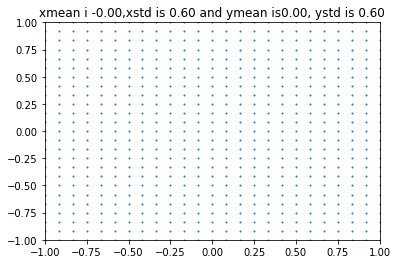

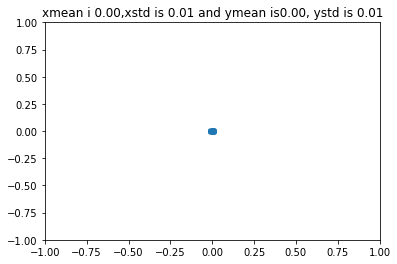

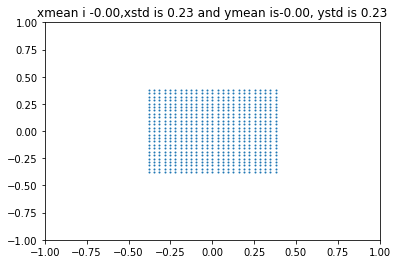

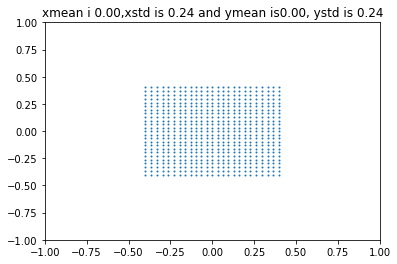

In [497]:
x=20
f=7.6
vis10=Visualization(simulation=run_lens_sim_ASPH(pos=[0,0,x],centre=[0,0]))
vis10.showpos_single(pos=x-2.75/2)
vis10.showpos_single(pos=x+f)

x=8.61
f=400
vis10=Visualization(simulation=run_lens_sim_ASPH_r(pos=[0,0,x],centre=[0,0]))
vis10.showpos_single(pos=x-2.75/2)
vis10.showpos_single(pos=x+f)


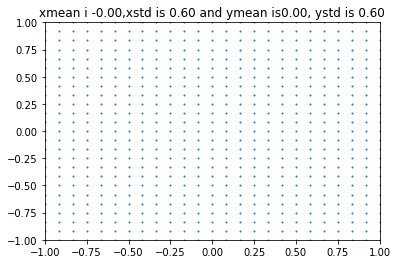

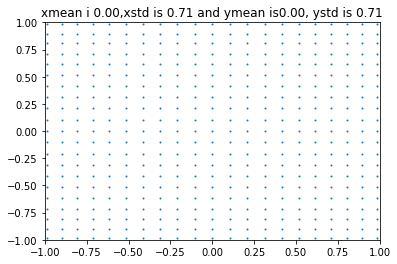

In [517]:
# x=20
# f=14.2
# vis10=Visualization(simulation=run_lens_sim_ASPH_r(pos=[0,0,x],centre=[0,0]))
# vis10.showpos_single(pos=x-2.75/2)
# vis10.showpos_single(pos=x+f)

x=12
f=x+5
vis10=Visualization(simulation=run_lens_sim_ASPH(pos=[0,0,x],centre=[0,0]))
vis10.showpos_single(pos=x-2.75/2)
vis10.showpos_single(pos=x+f)


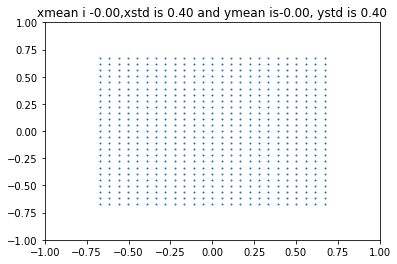

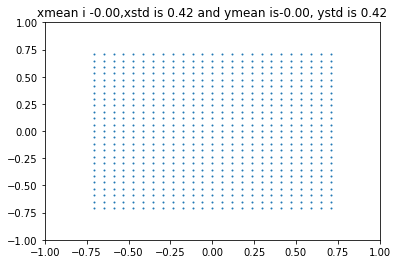

In [461]:
# x=10
# f=30

# vis10=Visualization(simulation=run_lens_sim_ACH_aitor(pos=[0,0,x],centre=[0,0]))
# vis10.showpos_single(pos=x-1.3)
# vis10.showpos_single(pos=x+f)


x=13.37
f=1

vis10=Visualization(simulation=run_lens_sim_ACH_aitor_r(pos=[0,0,x],centre=[0,0]))
vis10.showpos_single(pos=x)
vis10.showpos_single(pos=x+f)


In [74]:
get_coinc_evol([0,0,0],15,0.025,0.1,150,50)

343

In [29]:
2.355*0.060/sqrt(2)

0.09991418818165915

In [442]:
np.split(np.array([[[1,2],[1,3]],[[3,2],[1,2]],[[2,1],[2,2]],[[4,4],[4,4]]]),[1,3],axis=0)

[array([[[1, 2],
         [1, 3]]]), array([[[3, 2],
         [1, 2]],
 
        [[2, 1],
         [2, 2]]]), array([[[4, 4],
         [4, 4]]])]

2.0673226124315613

In [34]:
np.full((1,10),1,dtype=float)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [103]:
np.where([True,True,False],[1,1,1],[0,0,0]).dtype

dtype('int32')

In [9]:
Lens.asph_coeff[0][0]

[0, 0, 0.0005069957, 1.013651e-05, 8.523273e-07, 0]

TypeError: float() argument must be a string or a number, not 'list'

In [7]:
ACH=Lens.achromat(position = [0,0,rays_end+20+lensd*5],centre=[-0.6,0,0],f=200)


In [12]:
ACH[0]

TypeError: 'NoneType' object is not subscriptable

In [104]:
test_array=np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5]])

In [111]:
np.dot(np.reshape(test_array,np.flipud(test_array.shape)),test_array)

array([[24, 24, 24],
       [49, 49, 49],
       [72, 72, 72]])

In [108]:
np.flipud(test_array.shape)

array([3, 5])

In [118]:
(test_array*test_array).sum(axis=1)

array([ 3, 12, 27, 48, 75])

In [28]:
lensd_result

[[array([  3.58483417e+01,  -3.79357655e-02,   3.02276997e-02]),
  array([  3.63075789e+01,   1.40402626e-02,   2.44445545e-03]),
  array([  3.55424520e+01,  -8.90624797e-02,  -3.54859813e-02]),
  array([  3.54388655e+01,   3.94129711e-02,  -1.22498794e-02]),
  array([  3.49315166e+01,   2.63012271e-03,  -2.01453640e-02]),
  array([  3.59428762e+01,   4.33398792e-02,  -6.51852534e-03]),
  array([  3.56903950e+01,   9.01765459e-02,  -2.90368658e-02]),
  array([  3.49505697e+01,   1.23865294e-02,   2.31968948e-02]),
  array([  3.48506008e+01,   1.45137644e-02,   3.27148998e-03]),
  array([  3.59009502e+01,  -1.66829268e-02,   4.18205497e-02]),
  array([  3.45146568e+01,  -8.84837840e-02,  -2.66862805e-03]),
  array([  3.46819879e+01,   9.93441882e-03,   1.25283619e-02]),
  array([  3.40625290e+01,  -3.57628149e-02,   7.54629970e-03]),
  array([  3.26310073e+01,   6.35276379e-02,  -9.23469665e-03]),
  array([  3.42763632e+01,   9.56490217e-04,  -3.05643664e-02]),
  array([  3.53952612e+01

In [32]:
lensd_coinc

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

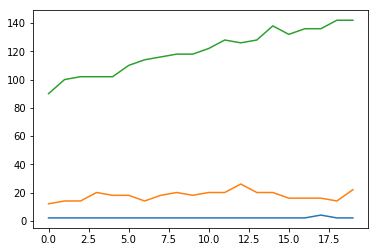

In [23]:
plt.figure()
plt.plot(np.array(lensd_coinc).T)
plt.show()

In [9]:
np.zeros(10)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])